In [102]:
%matplotlib inline
import glob
import os
import pandas as pd
import json
import numpy as np
import scipy.stats as ss
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')


# Metric for nighborhood influnce
The intuition is weight of influencee is more important than the influencer. For example, if the influencer weight is 0.2 and influencee is 0.9, it means that 20% of outgoing flow of influencer goes to influencee and it represents 90% of the incoming flow in influencee. So, the influencer have a higher importance in influencee flow. Conversely,  if the influencer weight of influencer is 0.9 and influencee is 0.2, it means that 90% or outgoing flow of influencer goes to influencee, but it represents only 20% of the incoming flow in influencee. So, the importance of influencer for the flow in influencee is not high and receive a low value.

Taking this into account, we  propose a metric based on the beta probability density function which has support $x \in [0,1]$ and $y \in [0, a]$ with parameters $alpha >= 2$ and $beta = 1$.

$f(x, a, b) = \frac{\gamma(a+b) x^{a-1} (1-x)^{b-1}}{\gamma(a) \gamma(b)}$

The line blue in figure below represents the beta pdf with paramenter $alpha >= 2$ and $beta = 1$.

![](http://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/531px-Beta_distribution_pdf.svg.png)




In [103]:
def influence(x, y, a):
    b=1
    return ((ss.beta.pdf(x, a, b) + y) / (a + 1))

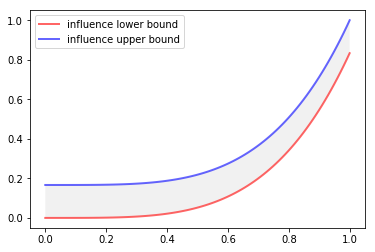

In [110]:
one =np.linspace(1,1,100)
zero =np.linspace(0,0,100)
x = np.linspace(0,1,100)

inf_l = influence(x, zero, a)
inf_u = influence(x, one , a)

a=5
fig, ax = plt.subplots()
ax.plot(x, inf_l ,'r-', lw=2, alpha=0.6, label='influence lower bound')
ax.plot(x, inf_u ,'b-', lw=2, alpha=0.6, label='influence upper bound')
ax.fill_between(x, inf_l, inf_u, facecolor='lightgrey',alpha=0.3,  interpolate=True)
plt.legend()

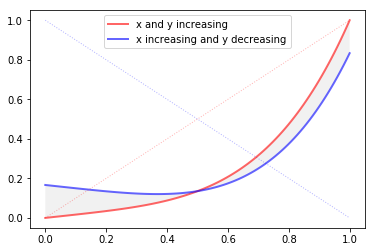

In [115]:
y = np.linspace(1,0,100)
x = np.linspace(0,1,100)

inf_i = influence(x, x, a)
inf_d = influence(x, y , a)

a=5
fig, ax = plt.subplots()
ax.plot(x, inf_i ,'r-', lw=2, alpha=0.6, label='x and y increasing')
ax.plot(x, inf_d ,'b-', lw=2, alpha=0.6, label='x increasing and y decreasing')
ax.fill_between(x, inf_i, inf_d, facecolor='lightgrey',alpha=0.3,  interpolate=True)
ax.plot(x, x,'r:', lw=1, alpha=0.3)
ax.plot(x, y,'b:', lw=1, alpha=0.3)
plt.legend()

In [329]:
hour = 12
all_files = glob.glob(os.path.join(os.getcwd() + "/graphs/", "*%sH.csv" % hour))
dfs = []
for filename in all_files:
    dfs.append(pd.read_csv(filename, header=None, names=['in','out', 'influence']))

In [330]:
for i, tmp in enumerate(dfs):
    dfs[i].influence = tmp.influence.apply(lambda x: json.loads(x.replace("'",'"'))["weight"])


In [331]:
df = pd.DataFrame(columns=['in','out', 'influence'])
for dt_frame in dfs:
    df = df.merge(dt_frame, how = 'outer', on = ['in','out'])

Find all columns with NAN

In [332]:
df.isna().all()

influence_x     True
in             False
out            False
influence_y    False
influence_x    False
influence_y    False
influence_x    False
influence_y    False
influence_x    False
influence_y    False
influence_x    False
influence_y    False
influence_x    False
influence_y    False
dtype: bool

Remove the 0 columns where all values are NAN

In [333]:
df = df.iloc[:,1:]

Change NaN values to 0

In [334]:
df = df.fillna(0)


In [335]:
df.head()

,in,out,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y
0,3397836578,3271850052,0.167184,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,494814016,3271850052,0.078669,0.000000,0.000000,0.079449,0.165573,0.085416,0.0,0.166667,0.0,0.166667,0.0
2,494814016,111586252,0.088022,0.166667,0.166667,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,5617993834,1940405974,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,2484268630,243356572,0.253095,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


Get the lines which have more than 5 non zero values.

In [336]:
sample = df[(df.iloc[:,2:] > 0).sum(axis=1) >5]

In [337]:
sample

,in,out,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y
1,494814016,3271850052,0.078669,0.000000,0.000000,0.079449,0.165573,0.085416,0.000000,0.166667,0.000000,0.166667,0.000000
10,3271850052,494814016,0.848099,0.000000,0.042674,0.000000,0.046944,0.011182,0.835960,0.835124,0.008765,0.000000,0.000000
12,3271850052,111586252,0.061488,0.061830,0.812243,0.000000,0.046052,0.115197,0.017824,0.082472,0.086061,0.608854,0.031265
27,392204795,1236745500,1.000000,0.000000,0.000000,0.220037,0.219061,0.000000,1.000000,1.000000,0.170285,1.000000,0.000000
57,914243522,3271850052,0.058903,0.000000,0.034939,0.169678,0.000000,0.038919,0.000000,0.102032,0.166718,0.000000,0.077230
242,111586252,3271850052,0.000000,0.190224,0.053273,0.000000,0.058485,0.137885,0.122273,0.054559,0.118681,0.181605,0.168000
250,3271850052,3391850893,0.000000,0.051263,0.051619,0.164485,0.051288,0.833743,0.833554,0.137634,0.051395,0.163427,0.000000
260,3271850052,914243522,0.000000,0.012384,0.016664,0.000000,0.000000,0.311758,0.000000,0.145746,0.359663,0.026797,0.036332
266,3271850052,4039511540,0.000000,0.840999,0.000000,0.846317,0.134212,0.015498,0.000000,0.000000,0.846771,0.854239,0.000000
370,3391850893,3271850052,0.000000,0.055434,0.000000,0.166667,0.124827,0.124932,0.000000,0.066663,0.166667,0.072329,0.000000


# Augmented Dickey-Fuller test
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

The code below select the stationary ones

In [338]:
sample[sample.iloc[:,2:].apply(lambda x: adfuller(x.values)[1], axis=1) <= 0.05]

,in,out,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y,influence_x,influence_y
1,494814016,3271850052,0.078669,0.0,0.000000,0.079449,0.165573,0.085416,0.0,0.166667,0.000000,0.166667,0.00000
57,914243522,3271850052,0.058903,0.0,0.034939,0.169678,0.000000,0.038919,0.0,0.102032,0.166718,0.000000,0.07723


# Granger Causality Test
The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [339]:

def granger_total(df_g, t_slice, x, y, hour):
    x_tmp = df_g[(df_g.poi_id==x) & (df_g.hour==hour)].groupby(pd.Grouper(freq='W'))['hour'].count()
    y_tmp = df_g[(df_g.poi_id==y) & (df_g.hour==hour)].groupby(pd.Grouper(freq='W'))['hour'].count()
    x1 = np.nan_to_num(ss.zscore(x_tmp[t_slice].fillna(0)))
    y1 = np.nan_to_num(ss.zscore(y_tmp[t_slice].fillna(0)))
    tuples = list(zip(x1,y1))
    gc = grangercausalitytests(tuples, 2, addconst=True, verbose=False)
    return gc[1][0]['params_ftest'][1]

In [390]:
df_g = pd.read_pickle('poi_tw.pkl')
w = df_g.groupby(pd.Grouper(freq='W'))['hour'].count().index

# Removing irrelevants


In [395]:
(df_g.index.max() - df_g.index.min()).days / 7

10.0

In [403]:
pt = ss.poisson(20)
pt.cdf(13)

0.06612764095916597

In [404]:
pt.cdf(12)

0.03901199285499282

In [405]:
tmp = df_g.groupby([pd.Grouper(freq='W'),'poi_id'])
print(df_g.shape)
df_g = tmp.filter(lambda x: x['user'].nunique() > 12)
print(df_g.shape)
print(df_g.groupby(['poi_id']).user.count())

(22356, 7)
(20912, 7)
poi_id
4476353          31
32865746         56
32947040        152
35115840        198
99776277         25
111586252       938
168942988        14
358803374        93
368171371       125
389443002        32
389450322       121
427897097        30
494814016       300
636784895       125
806237000       117
914243522       431
3054493437      403
3271850052    16556
3391850893      674
3581990318       82
4039511540      409
Name: user, dtype: int64


In [406]:
sample['p-value'] = sample.apply(lambda row: granger_total(df_g, w, row['in'], row['out'], hour), axis=1)



In [407]:
sample.loc[sample['p-value'] <= 0.05, ['in','out','p-value']]


,in,out,p-value
57,914243522,3271850052,0.014196


In [408]:

def granger_unique(df_g, t_slice, x, y, hour):
    x_tmp = df_g[(df_g.poi_id==x) & (df_g.hour==hour)].groupby(pd.Grouper(freq='W')).user.nunique()
    y_tmp = df_g[(df_g.poi_id==y) & (df_g.hour==hour)].groupby(pd.Grouper(freq='W')).user.nunique()
    x1 = np.nan_to_num(ss.zscore(x_tmp[t_slice].fillna(0)))
    y1 = np.nan_to_num(ss.zscore(y_tmp[t_slice].fillna(0)))
    tuples = list(zip(x1,y1))
    gc = grangercausalitytests(tuples, 2, addconst=True, verbose=False)
    return gc[1][0]['params_ftest'][1]

In [409]:
sample['p-value'] = sample.apply(lambda row: granger_unique(df_g, w, row['in'], row['out'], hour), axis=1)

In [410]:
sample.loc[sample['p-value'] <= 0.05, ['in','out','p-value']]

,in,out,p-value
57,914243522,3271850052,0.019622
